Replacing Conv2D with Blurpool

In [3]:
import os
import urllib.request
import zipfile

def download_tiny_imagenet(data_dir='./data'):
    os.makedirs(data_dir, exist_ok=True)
    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
    zip_path = os.path.join(data_dir, 'tiny-imagenet-200.zip')

    if not os.path.exists(os.path.join(data_dir, 'tiny-imagenet-200')):
        print("Downloading Tiny ImageNet...")
        urllib.request.urlretrieve(url, zip_path)
        print("Extracting...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        os.remove(zip_path)
        print("Done!")
    else:
        print("Tiny ImageNet already downloaded.")

    return os.path.join(data_dir, 'tiny-imagenet-200')


### **Albumentations Transforms**

(https://github.com/albumentations-team/albumentations)

It defines train_tfms using A.Compose to chain together several augmentation techniques from albumentations.

It defines train_tfms using `A.Compose` to chain together several augmentation techniques from albumentations

1. `A.HorizontalFlip`: Randomly flips images horizontally.
2. `A.ShiftScaleRotate`: Applies random affine transformations (shifting, scaling, and rotating).
3. `A.CoarseDropout`: (this is **CutOut**) Randomly drops rectangular regions from the image and fills them with the calculated mean value.
4. `A.Normalize`: Normalizes the pixel values using the pre-computed `MEAN` and `STD`.
5. `ToTensorV2`: Converts the augmented image (which is a NumPy array at this point in the albumentations pipeline) into a PyTorch tensor and moves the channel dimension to the front (C, H, W).

`AlbuTinyImageNet` Dataset Class: It creates a custom Dataset class AlbuCIFAR that wraps the standard tiny imagenet dataset. T**his is necessary because albumentations works with NumPy arrays in HWC (Height, Width, Channel) format, while torchvision datasets return PIL Images (which are converted to tensors in C, H, W format by their default ToTensor)**. The __getitem__ method converts the PIL Image to a NumPy array before applying the albumentations transform.





In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import os

# ImageNet normalization stats (standard for ImageNet-based datasets)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

# Convert to 0..255 for fill_value
fill_value_255 = tuple(int(m * 255) for m in MEAN)

def get_train_transforms(image_size=64):
    return A.Compose([
        A.Resize(image_size, image_size) if image_size != 64 else A.NoOp(),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.10, rotate_limit=15, p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
        A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
                        min_holes=1, min_height=int(image_size*0.25), min_width=int(image_size*0.25),
                        fill_value=fill_value_255, p=0.5),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ])

def get_val_transforms(image_size=64):
    return A.Compose([
        A.Resize(image_size, image_size) if image_size != 64 else A.NoOp(),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ])

class AlbuTinyImageNet(Dataset):
    def __init__(self, root, train=True, transform=None):
        split = 'train' if train else 'val'
        self.ds = datasets.ImageFolder(os.path.join(root, split))
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]  # PIL Image
        img = np.array(img)        # -> HWC uint8 RGB
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        return img, label


In [5]:
def get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2):
    """
    Create train and validation dataloaders for Tiny ImageNet

    Args:
        data_path: Path to tiny-imagenet-200 directory
        batch_size: Batch size for training
        image_size: Target image size (64 for now, 224 for later)
        num_workers: Number of worker processes
    """
    train_tfms = get_train_transforms(image_size)
    val_tfms = get_val_transforms(image_size)

    train_ds = AlbuTinyImageNet(root=data_path, train=True, transform=train_tfms)
    val_ds = AlbuTinyImageNet(root=data_path, train=False, transform=val_tfms)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                             num_workers=num_workers, pin_memory=True,persistent_workers=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True,persistent_workers=True)

    return train_loader, val_loader


In [6]:
import os
import shutil

def reorganize_val_folder(data_path):
    """Reorganize Tiny ImageNet validation folder to work with ImageFolder"""
    val_dir = os.path.join(data_path, 'val')
    img_dir = os.path.join(val_dir, 'images')
    annotations_file = os.path.join(val_dir, 'val_annotations.txt')

    # Read annotations
    with open(annotations_file, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split('\t')
            img_name = parts[0]
            class_id = parts[1]

            # Create class folder if it doesn't exist
            class_folder = os.path.join(val_dir, class_id)
            os.makedirs(class_folder, exist_ok=True)

            # Move image to class folder
            src = os.path.join(img_dir, img_name)
            dst = os.path.join(class_folder, img_name)
            if os.path.exists(src):
                shutil.move(src, dst)

    # Remove empty images folder
    if os.path.exists(img_dir) and not os.listdir(img_dir):
        os.rmdir(img_dir)

    print("Validation folder reorganized successfully!")

In [7]:
# Download data
data_path = download_tiny_imagenet()

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

Extracting...
Done!


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_37/1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),


**Quick sanity check**

In [8]:
# Peek a batch and verify normalization stats roughly centered
imgs, labels = next(iter(train_loader))
print("Batch shape:", imgs.shape, "| dtype:", imgs.dtype, "| range ~", (imgs.min().item(), imgs.max().item()))
print("Per-channel mean (batch):", imgs.mean(dim=(0,2,3)))
print("Per-channel std  (batch):", imgs.std(dim=(0,2,3)))

Batch shape: torch.Size([128, 3, 64, 64]) | dtype: torch.float32 | range ~ (-2.1179039478302, 2.6399998664855957)
Per-channel mean (batch): tensor([-0.1808, -0.1615, -0.1420])
Per-channel std  (batch): tensor([1.2673, 1.2584, 1.2704])


**Helper: denormalize + show grid**

In [9]:
# Utils to denormalize and visualize a small grid of images
import math
import torch
import matplotlib.pyplot as plt

# Use MEAN/STD computed earlier (lists) and make tensors for broadcasting
_MEAN = torch.tensor(MEAN).view(1, 3, 1, 1)
_STD  = torch.tensor(STD).view(1, 3, 1, 1)

def denorm(imgs):
    """imgs: tensor [B,C,H,W] normalized with MEAN/STD -> return in [0,1]"""
    x = imgs.clone().cpu()
    x = x * _STD + _MEAN
    return x.clamp(0.0, 1.0)

def show_batch(images, labels, class_names, n=16, cols=8):
    """
    Show n images with titles (class names) in a grid.
    images: [B,C,H,W] tensor (normalized)
    labels: [B] tensor
    """
    n = min(n, images.size(0))
    rows = math.ceil(n / cols)
    imgs = denorm(images[:n])

    plt.figure(figsize=(1.8*cols, 1.8*rows))
    for i in range(n):
        img = imgs[i].permute(1, 2, 0).numpy()  # HWC
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_title(class_names[int(labels[i])], fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


**View a random training batch (with augmentations)**

/tmp/ipykernel_37/1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),


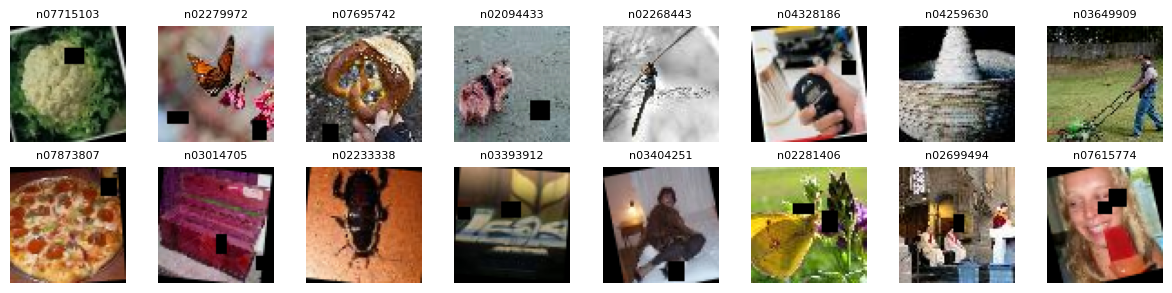

In [10]:
import matplotlib.pyplot as plt

train_ds = AlbuTinyImageNet(root=data_path, train=True, transform=get_train_transforms(64))
class_names = train_ds.ds.classes


def show_batch(images, labels, class_names, n=16, cols=8):
    """Display a batch of images with their labels."""
    n = min(n, len(images))
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    axes = axes.flatten() if n > 1 else [axes]

    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()  # CHW -> HWC
        img = img * np.array(STD) + np.array(MEAN)  # denormalize
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]], fontsize=8)
        axes[i].axis('off')

    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display batch
train_images, train_labels = next(iter(train_loader))
show_batch(train_images, train_labels, class_names, n=16, cols=8)


**View a random test batch (no augmentations)**

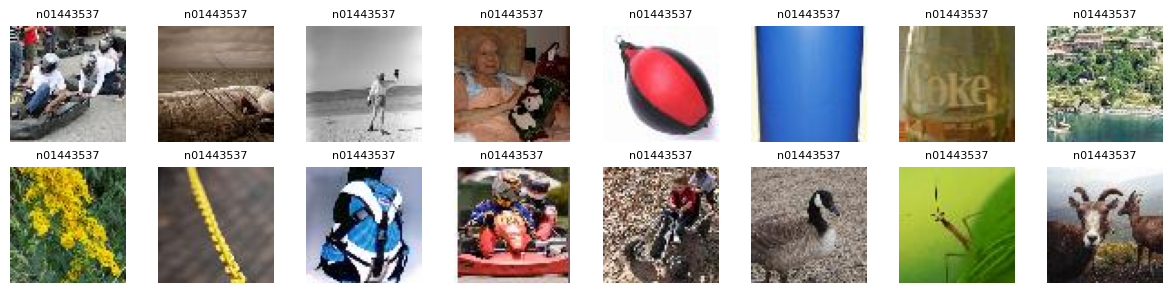

In [11]:
val_images, val_labels = next(iter(val_loader))
show_batch(val_images, val_labels, class_names, n=16, cols=8)

In [12]:
import numpy as np

def mixup_data(x, y, alpha=0.2, device='cuda'):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [13]:
def cutmix_data(x, y, alpha=1.0, device='cuda'):
    '''Returns CutMix inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    # Get random box
    W = x.size()[2]
    H = x.size()[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Uniform sampling
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    # Apply cutmix
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    # Adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))

    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam


In [14]:
class EMA:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        self.register()

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]
        self.backup = {}


In [15]:
import copy
import torch
import torch.nn.functional as F
from tqdm import tqdm

# keep your history lists (now store epoch-level stats)
train_losses, test_losses = [], []
train_acc,    test_acc    = [], []

class EarlyStopping:
    def __init__(self, patience=6, min_delta=1e-4, restore_best_weights=True, checkpoint_path=None):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.checkpoint_path = checkpoint_path
        self.best = float('inf')
        self.wait = 0
        self.best_state = None

    def step(self, val_loss, model):
        improved = (self.best - val_loss) > self.min_delta
        if improved:
            self.best = val_loss
            self.wait = 0
            if self.restore_best_weights:
                self.best_state = copy.deepcopy(model.state_dict())
            if self.checkpoint_path:
                torch.save(model.state_dict(), self.checkpoint_path)
        else:
            self.wait += 1
        return self.wait >= self.patience

    def load_best(self, model):
        if self.restore_best_weights and self.best_state is not None:
            model.load_state_dict(self.best_state)
        elif self.checkpoint_path:
            model.load_state_dict(torch.load(self.checkpoint_path, map_location="cpu"))

# mix precision training loop with gradient clipping

from torch.cuda.amp import autocast, GradScaler

def train(model, device, train_loader, optimizer, scheduler, epoch, scaler, mixup_alpha=0.2):
    model.train()
    pbar = tqdm(train_loader, desc=f"Train E{epoch:02d}")
    correct, total = 0, 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)

        # Apply mixup
        if np.random.random() > 0.5:
            data, targets_a, targets_b, lam = mixup_data(data, target, mixup_alpha, device)
        else:
            data, targets_a, targets_b, lam = cutmix_data(data, target, 1.0, device)

        optimizer.zero_grad()

        with autocast():
            y_pred = model(data)
            loss = mixup_criterion(
                lambda pred, y: F.cross_entropy(pred, y, label_smoothing=0.1),
                y_pred, targets_a, targets_b, lam
            )

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # Update EMA
        # ema.update()

        # stats
        running_loss += loss.item() * data.size(0)
        pred = y_pred.argmax(dim=1)
        correct += (lam * pred.eq(targets_a).sum().float()
                    + (1 - lam) * pred.eq(targets_b).sum().float()).item()
        total += data.size(0)

        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*correct/total:.2f}%")

    epoch_loss = running_loss / total
    epoch_acc  = 100.0 * correct / total
    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    return epoch_loss, epoch_acc


def test(model, device, test_loader, epoch=None):
    model.eval()
    test_loss_sum, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target, reduction='sum', label_smoothing=0.1)  # sum over batch
            test_loss_sum += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += data.size(0)

    avg_loss = test_loss_sum / total
    acc = 100.0 * correct / total
    test_losses.append(avg_loss)
    test_acc.append(acc)

    if epoch is not None:
        print(f"\nVal E{epoch:02d}: loss={avg_loss:.4f}, acc={correct}/{total} ({acc:.2f}%)\n")
    else:
        print(f"\nVal: loss={avg_loss:.4f}, acc={correct}/{total} ({acc:.2f}%)\n")

    return avg_loss, acc


### ResNet with ReLu with conv instead of fc

In [ ]:
# #Commented
# %pip install antialiased_cnns
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import antialiased_cnns

# class BasicBlock(nn.Module):
#     """Original ResNet Basic Block"""
#     expansion = 1

#     def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
#                                stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
#                                stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.downsample = downsample

#     def forward(self, x):
#         identity = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = F.relu(out, inplace=True)

#         out = self.conv2(out)
#         out = self.bn2(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = F.relu(out, inplace=True)  # ReLU after addition!

#         return out


# class BottleneckBlock(nn.Module):
#     """Original ResNet Bottleneck Block"""
#     expansion = 4

#     def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)

#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
#                                stride=stride, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)

#         self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
#                                kernel_size=1, bias=False)
#         self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

#         self.downsample = downsample

#     def forward(self, x):
#       identity = x

#       out = self.conv1(x)
#       out = self.bn1(out)
#       out = F.relu(out, inplace=True)

#       out = self.conv2(out)  # <- Fixed: was self.conv2(x)
#       out = self.bn2(out)
#       out = F.relu(out, inplace=True)

#       out = self.conv3(out)
#       out = self.bn3(out)

#       if self.downsample is not None:
#           identity = self.downsample(x)

#       out += identity
#       out = F.relu(out, inplace=True)

#       return out



# class ResNet(nn.Module):

#     def __init__(self, block, layers, num_classes=1000, use_blurpool=False):
#         super().__init__()
#         self.in_channels = 64
#         self.use_blurpool = use_blurpool

#         # Initial conv layer with potential blurpool
#         if self.use_blurpool:
#             self.conv1 = nn.Sequential(
#                 nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False),
#                 nn.BatchNorm2d(64),
#                 nn.ReLU(inplace=True),
#                 antialiased_cnns.BlurPool(64, stride=2)
#             )
#         else:
#             self.conv1 = nn.Sequential(
#                 nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
#                 nn.BatchNorm2d(64),
#                 nn.ReLU(inplace=True)
#             )


#         # ResNet layers
#         self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

#         # Final classifier
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         # self.fc = nn.Linear(512 * block.expansion, num_classes)
#         self.fc = nn.Conv2d(512 * block.expansion, num_classes, kernel_size=1)

#     def _make_layer(self, block, out_channels, blocks, stride):
#         downsample = None
#         if stride != 1 or self.in_channels != out_channels * block.expansion:
#             if self.use_blurpool and stride == 2:
#                  downsample = nn.Sequential(
#                     nn.Conv2d(self.in_channels, out_channels * block.expansion,
#                             kernel_size=1, stride=1, bias=False),
#                     nn.BatchNorm2d(out_channels * block.expansion),
#                     antialiased_cnns.BlurPool(out_channels * block.expansion, stride=2)
#                 )
#             else:
#                 downsample = nn.Sequential(
#                     nn.Conv2d(self.in_channels, out_channels * block.expansion,
#                             kernel_size=1, stride=stride, bias=False),
#                     nn.BatchNorm2d(out_channels * block.expansion)
#                 )


#         layers = []
#         layers.append(block(self.in_channels, out_channels, stride, downsample))
#         self.in_channels = out_channels * block.expansion

#         for _ in range(1, blocks):
#             layers.append(block(self.in_channels, out_channels))

#         return nn.Sequential(*layers)

#     def forward(self, x):
#         x = self.conv1(x)
#         # x = self.bn1(x) # Remove these as they are now in conv1 sequential
#         # x = F.relu(x, inplace=True)
#         x = self.maxpool_or_blurpool(x) # This is for the initial layer, needs fixing

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = self.fc(x)
#         x = torch.flatten(x, 1)

#         return x

# # Factory functions

# def resnet50_with_relu_conv(num_classes=1000, use_blurpool=False):
#     return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes, use_blurpool=use_blurpool)

In [ ]:
# model = resnet50_with_relu(num_classes=200)
# model = resnet50(num_classes=200)
#Commented
# model = resnet50_with_relu_conv(num_classes=200, use_blurpool=True) # Set use_blurpool to True
# model = resnet50(num_classes=1000, drop_path_rate=0.2, use_blurpool=True) # Set use_blurpool to True

In [ ]:
# #Commented
# %pip install torchsummary
# from torchsummary import summary
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# print(device)

# model = model.to(device)
# summary(model, input_size=(3, 64, 64)) # Changed input size to match Tiny ImageNet size

In [16]:
%pip install antialiased_cnns
import torch
import torch.nn as nn
import torch.nn.functional as F
import antialiased_cnns


def drop_path(x, drop_prob=0.0, training=False):
    """Drop paths (Stochastic Depth) per sample."""
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()
    output = x.div(keep_prob) * random_tensor
    return output


class BasicBlock(nn.Module):
    """Original ResNet Basic Block with Stochastic Depth"""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, drop_prob=0.0, use_blurpool=False):
        super().__init__()
        self.use_blurpool = use_blurpool
        self.stride = stride

        # Modify conv1 based on stride and use_blurpool
        if self.use_blurpool and self.stride == 2:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                                   stride=1, padding=1, bias=False)
            self.blurpool = antialiased_cnns.BlurPool(out_channels, stride=2)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                                   stride=stride, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.drop_prob = drop_prob

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        # Apply blurpool after conv1 if downsampling with blurpool
        if self.use_blurpool and self.stride == 2:
             out = self.blurpool(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = drop_path(out, self.drop_prob, self.training)
        out += identity
        out = F.relu(out, inplace=True)

        return out


class BottleneckBlock(nn.Module):
    """Original ResNet Bottleneck Block with Stochastic Depth"""
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, drop_prob=0.0, use_blurpool=False):
        super().__init__()
        self.use_blurpool = use_blurpool
        self.stride = stride

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Modify conv2 based on stride and use_blurpool
        if self.use_blurpool and self.stride == 2:
             self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
             self.blurpool = antialiased_cnns.BlurPool(out_channels, stride=2)
        else:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.downsample = downsample
        self.drop_prob = drop_prob


    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out, inplace=True)

        # Apply blurpool after conv2 if downsampling with blurpool
        if self.use_blurpool and self.stride == 2:
             out = self.blurpool(out)


        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = drop_path(out, self.drop_prob, self.training)
        out += identity
        out = F.relu(out, inplace=True)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, drop_path_rate=0.2, use_blurpool=False):
        super().__init__()
        self.in_channels = 64
        self.use_blurpool = use_blurpool

        # Initial conv layer
        # Apply blurpool if use_blurpool is True and stride is 2
        if self.use_blurpool:
            self.conv1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                antialiased_cnns.BlurPool(64, stride=2)
            )
        else:
            self.conv1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            )

        # Initial pooling layer (always MaxPool2d stride 2)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        # Calculate total number of blocks
        total_blocks = sum(layers)
        # Linear drop path rate schedule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, total_blocks)]

        # Track current block index
        block_idx = 0

        self.layer1 = self._make_layer(block, 64, layers[0], stride=1,
                                       drop_probs=dpr[block_idx:block_idx+layers[0]], use_blurpool=use_blurpool)
        block_idx += layers[0]

        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       drop_probs=dpr[block_idx:block_idx+layers[1]], use_blurpool=use_blurpool)
        block_idx += layers[1]

        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       drop_probs=dpr[block_idx:block_idx+layers[2]], use_blurpool=use_blurpool)
        block_idx += layers[2]

        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       drop_probs=dpr[block_idx:block_idx+layers[3]], use_blurpool=use_blurpool)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Conv2d(512 * block.expansion, num_classes, kernel_size=1)

    def _make_layer(self, block, out_channels, blocks, stride, drop_probs, use_blurpool):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            # Downsample path
            # If use_blurpool is True and stride is 2, replace strided conv with conv stride 1 + blurpool stride 2
            if use_blurpool and stride == 2:
                 downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, out_channels * block.expansion,
                            kernel_size=1, stride=1, bias=False), # Conv stride 1
                    nn.BatchNorm2d(out_channels * block.expansion),
                    antialiased_cnns.BlurPool(out_channels * block.expansion, stride=2) # BlurPool stride 2
                )
            else:
                downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, out_channels * block.expansion,
                            kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels * block.expansion)
                )


        layers = []
        # First block in the layer handles downsampling
        layers.append(block(self.in_channels, out_channels, stride, downsample, drop_probs[0], use_blurpool=use_blurpool))
        self.in_channels = out_channels * block.expansion

        # Subsequent blocks have stride 1
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, stride=1, drop_prob=drop_probs[i], use_blurpool=use_blurpool))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        # The original ResNet has maxpool after conv1
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.fc(x)
        x = torch.flatten(x, 1)

        return x

def resnet50(num_classes=1000, drop_path_rate=0.2, use_blurpool=False):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes, drop_path_rate, use_blurpool)

Note: you may need to restart the kernel to use updated packages.


### model & model summary

In [17]:
# model = resnet50_with_relu(num_classes=200)
# model = resnet50(num_classes=200)
# model = resnet50_with_relu_conv(num_classes=200)
model = resnet50(num_classes=1000, drop_path_rate=0.2, use_blurpool=True)

In [18]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = model.to(device)
summary(model, input_size=(3, 64, 64)) # Changed input size to match Tiny ImageNet size

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
   ReflectionPad2d-4           [-1, 64, 67, 67]               0
          BlurPool-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]           4,096
       BatchNorm2d-8           [-1, 64, 16, 16]             128
            Conv2d-9           [-1, 64, 16, 16]          36,864
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1,

In [ ]:
##Commented
# Define the model without use_blurpool
# model = resnet50(num_classes=1000, drop_path_rate=0.2)

In [ ]:
##Commented
# from torchsummary import summary
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# print(device)

# model = model.to(device)
# summary(model, input_size=(3, 64, 64)) # Changed input size to match Tiny ImageNet size

### Finding the learning rate for OneCylePolicy LR Scheduler

In [ ]:
##Commented
# Re-define the model with the corrected class
# model = resnet50_with_relu(num_classes=200)
# model = resnet50(num_classes=200)
# model = resnet50_with_relu_conv(num_classes=200)
# model = resnet50(num_classes=1000, drop_path_rate=0.2, use_blurpool=True)

In [ ]:
##Commented
# from torchsummary import summary
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# print(device)

# model = model.to(device)
# summary(model, input_size=(3, 64, 64)) # Changed input size to match Tiny ImageNet size

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.95E-05


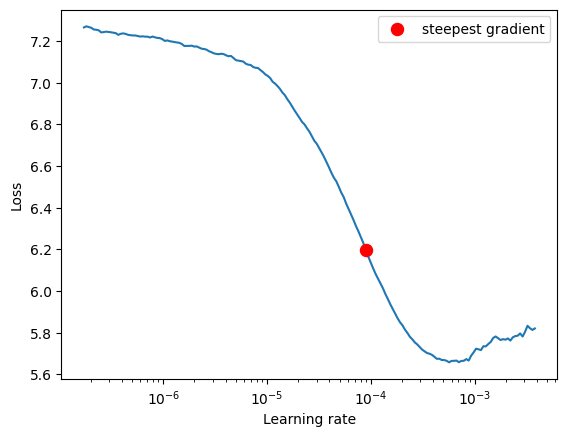

In [19]:
# Install if needed
%pip install torch-lr-finder

import torch.optim as optim
from torch_lr_finder import LRFinder

# Create fresh model and optimizer
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-7, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# Run LR finder
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=0.005, num_iter=200)
lr_finder.plot()  # Shows the loss vs learning rate
lr_finder.reset()  # Reset model and optimizer

### **run it!! - reorganize validation files (important to run once)**

In [20]:
# Run it
reorganize_val_folder(data_path)

Validation folder reorganized successfully!


### ResNet50 + conv instead of fc + mixed precision + mixup + weight decay increased to 5e-3

**Observation**: new high accuracy of ~ 50% was reached
tried running with EMA but accuracy was stuck at 0.5% maybe decay param is wrong

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)
# model = resnet50_with_relu_conv(num_classes=200,drop_path_rate=0.2, use_blurpool=True).to(device)
model = resnet50(num_classes=200,drop_path_rate=0.2, use_blurpool=True).to(device)
optimizer = optim.AdamW(model.parameters(), lr=8.95E-05, weight_decay=5e-3)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=8.95E-04,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

scaler = GradScaler()
# ema = EMA(model, decay=0.9999)

EPOCHS = 100
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch, scaler)

    # Use EMA weights for validation
    # ema.apply_shadow()
    val_loss, val_acc = test(model, device, val_loader, epoch)
    # ema.restore()

    # Save if best accuracy
    if epoch > 20:# start saving only after 20th epoch
      if val_acc > best_acc:
          best_acc = val_acc
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'accuracy': val_acc,
              'loss': val_loss
          }, checkpoint_path)
          print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")

### ResNet50 + conv instead of fc + mixed precision + mixup + weight decay increased to 5e-3 + **Progressive Batch Size Resizing**

**Observation**: new high accuracy of ~ 56% was reached
very good overall acceleration of occuracy

In [22]:
def get_image_size_for_epoch(epoch):
    """Return image size based on epoch"""
    if epoch <= 30:
        return 64
    elif epoch <= 60:
        return 128
    else:
        return 224

def get_batch_size(image_size):
    """Return batch size based on image size"""
    if image_size == 64:
        return 128
    elif image_size == 128:
        return 64
    else:
        return 64

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

# model = resnet50_with_relu_conv(num_classes=200).to(device)
model = resnet50(num_classes=200,drop_path_rate=0.2, use_blurpool=True).to(device)
optimizer = optim.AdamW(model.parameters(), lr=8.95E-05, weight_decay=5e-3)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=8.95E-04,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

# In your training loop:
scaler = GradScaler()
current_size = None

batch_size = 128
EPOCHS = 100

for epoch in range(1, EPOCHS + 1):
    # Check if we need to change image size
    new_size = get_image_size_for_epoch(epoch)
    if new_size != current_size:
        print(f"\n{'='*50}")
        print(f"Switching to image size: {new_size}x{new_size}")
        print(f"{'='*50}\n")

        batch_size = get_batch_size(new_size)

        # Recreate dataloaders with new size
        train_loader, val_loader = get_dataloaders(data_path, batch_size=batch_size,
                                                    image_size=new_size, num_workers=2)
        current_size = new_size

    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch, scaler, mixup_alpha=0.2)
    val_loss, val_acc = test(model, device, val_loader, epoch)

     # Save if best accuracy
    if epoch > 20:# start saving only after 20th epoch
      if val_acc > best_acc:
          best_acc = val_acc
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'accuracy': val_acc,
              'loss': val_loss
          }, checkpoint_path)
          print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")




Device: cuda


/tmp/ipykernel_37/1280161786.py:22: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=int(image_size*0.25), max_width=int(image_size*0.25),
/tmp/ipykernel_37/2306252017.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Switching to image size: 64x64



Train E01:   0%|          | 0/782 [00:00<?, ?it/s]/tmp/ipykernel_37/188773879.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Train E01: 100%|██████████| 782/782 [01:36<00:00,  8.14it/s, acc=2.14%, loss=4.7218]



Val E01: loss=4.8186, acc=627/10000 (6.27%)



Train E02: 100%|██████████| 782/782 [01:35<00:00,  8.23it/s, acc=5.12%, loss=4.7411]



Val E02: loss=4.4448, acc=1075/10000 (10.75%)



Train E03: 100%|██████████| 782/782 [01:34<00:00,  8.23it/s, acc=8.08%, loss=5.0041]



Val E03: loss=4.2168, acc=1486/10000 (14.86%)



Train E04: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=9.98%, loss=4.7301]



Val E04: loss=4.0500, acc=1856/10000 (18.56%)



Train E05: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=12.02%, loss=4.3402]



Val E05: loss=3.9635, acc=2054/10000 (20.54%)



Train E06: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=13.76%, loss=3.8867]



Val E06: loss=4.0306, acc=2241/10000 (22.41%)



Train E07: 100%|██████████| 782/782 [01:34<00:00,  8.23it/s, acc=14.53%, loss=4.2779]



Val E07: loss=3.8600, acc=2369/10000 (23.69%)



Train E08: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=15.74%, loss=3.9707]



Val E08: loss=3.8572, acc=2488/10000 (24.88%)



Train E09: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=17.16%, loss=4.3040]



Val E09: loss=3.8832, acc=2706/10000 (27.06%)



Train E10: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=18.75%, loss=3.5918]



Val E10: loss=3.6920, acc=2838/10000 (28.38%)



Train E11: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=19.86%, loss=3.7298]



Val E11: loss=3.4753, acc=3046/10000 (30.46%)



Train E12: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=21.36%, loss=3.8171]



Val E12: loss=3.6017, acc=2813/10000 (28.13%)



Train E13: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=22.21%, loss=3.6710]



Val E13: loss=3.2947, acc=3431/10000 (34.31%)



Train E14: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=23.86%, loss=4.4240]



Val E14: loss=3.2674, acc=3587/10000 (35.87%)



Train E15: 100%|██████████| 782/782 [01:34<00:00,  8.23it/s, acc=26.12%, loss=2.9865]



Val E15: loss=3.3559, acc=3494/10000 (34.94%)



Train E16: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=26.70%, loss=3.3483]



Val E16: loss=3.1037, acc=3833/10000 (38.33%)



Train E17: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=27.44%, loss=3.0233]



Val E17: loss=3.0786, acc=3891/10000 (38.91%)



Train E18: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=28.79%, loss=2.4863]



Val E18: loss=3.0830, acc=3931/10000 (39.31%)



Train E19: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=29.45%, loss=3.8925]



Val E19: loss=3.0424, acc=4023/10000 (40.23%)



Train E20: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=30.42%, loss=3.1713]



Val E20: loss=2.8938, acc=4368/10000 (43.68%)



Train E21: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=31.85%, loss=3.3033]



Val E21: loss=2.9644, acc=4157/10000 (41.57%)

✓ Saved best model at epoch 21 with accuracy: 41.57%


Train E22: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=32.72%, loss=2.6637]



Val E22: loss=2.8759, acc=4507/10000 (45.07%)

✓ Saved best model at epoch 22 with accuracy: 45.07%


Train E23: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=34.17%, loss=2.7891]



Val E23: loss=2.7742, acc=4660/10000 (46.60%)

✓ Saved best model at epoch 23 with accuracy: 46.60%


Train E24: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=35.45%, loss=4.0348]



Val E24: loss=2.8451, acc=4477/10000 (44.77%)



Train E25: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=36.18%, loss=3.8731]



Val E25: loss=2.6840, acc=4894/10000 (48.94%)

✓ Saved best model at epoch 25 with accuracy: 48.94%


Train E26: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=37.40%, loss=2.2981]



Val E26: loss=2.6875, acc=4910/10000 (49.10%)

✓ Saved best model at epoch 26 with accuracy: 49.10%


Train E27: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=37.94%, loss=3.9193]



Val E27: loss=2.6830, acc=4970/10000 (49.70%)

✓ Saved best model at epoch 27 with accuracy: 49.70%


Train E28: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=39.67%, loss=4.7259]



Val E28: loss=2.6470, acc=4987/10000 (49.87%)

✓ Saved best model at epoch 28 with accuracy: 49.87%


Train E29: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=39.70%, loss=2.0432]



Val E29: loss=2.5884, acc=5129/10000 (51.29%)

✓ Saved best model at epoch 29 with accuracy: 51.29%


Train E30: 100%|██████████| 782/782 [01:34<00:00,  8.24it/s, acc=41.90%, loss=3.3485]



Val E30: loss=2.5794, acc=5247/10000 (52.47%)

✓ Saved best model at epoch 30 with accuracy: 52.47%

Switching to image size: 128x128



Train E31: 100%|██████████| 1563/1563 [05:00<00:00,  5.21it/s, acc=36.41%, loss=3.7398]



Val E31: loss=2.7221, acc=4838/10000 (48.38%)



Train E32: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=40.05%, loss=4.0798]



Val E32: loss=2.6528, acc=4995/10000 (49.95%)



Train E33: 100%|██████████| 1563/1563 [04:58<00:00,  5.23it/s, acc=42.46%, loss=2.7748]



Val E33: loss=2.4885, acc=5437/10000 (54.37%)

✓ Saved best model at epoch 33 with accuracy: 54.37%


Train E34: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=44.69%, loss=2.6125]



Val E34: loss=2.4379, acc=5594/10000 (55.94%)

✓ Saved best model at epoch 34 with accuracy: 55.94%


Train E35: 100%|██████████| 1563/1563 [04:58<00:00,  5.23it/s, acc=46.78%, loss=3.0160]



Val E35: loss=2.4487, acc=5541/10000 (55.41%)



Train E36: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=48.63%, loss=2.6413]



Val E36: loss=2.3465, acc=5811/10000 (58.11%)

✓ Saved best model at epoch 36 with accuracy: 58.11%


Train E37: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=50.78%, loss=3.6893]



Val E37: loss=2.2478, acc=6084/10000 (60.84%)

✓ Saved best model at epoch 37 with accuracy: 60.84%


Train E38: 100%|██████████| 1563/1563 [04:59<00:00,  5.21it/s, acc=52.38%, loss=3.2433]



Val E38: loss=2.2556, acc=6088/10000 (60.88%)

✓ Saved best model at epoch 38 with accuracy: 60.88%


Train E39: 100%|██████████| 1563/1563 [04:59<00:00,  5.21it/s, acc=53.86%, loss=1.9283]



Val E39: loss=2.2474, acc=6142/10000 (61.42%)

✓ Saved best model at epoch 39 with accuracy: 61.42%


Train E40: 100%|██████████| 1563/1563 [05:00<00:00,  5.21it/s, acc=54.75%, loss=3.6379]



Val E40: loss=2.1914, acc=6280/10000 (62.80%)

✓ Saved best model at epoch 40 with accuracy: 62.80%


Train E41: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=57.14%, loss=2.2140]



Val E41: loss=2.1808, acc=6388/10000 (63.88%)

✓ Saved best model at epoch 41 with accuracy: 63.88%


Train E42: 100%|██████████| 1563/1563 [05:00<00:00,  5.21it/s, acc=58.75%, loss=3.5172]



Val E42: loss=2.1539, acc=6402/10000 (64.02%)

✓ Saved best model at epoch 42 with accuracy: 64.02%


Train E43: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=60.05%, loss=3.3122]



Val E43: loss=2.2096, acc=6310/10000 (63.10%)



Train E44: 100%|██████████| 1563/1563 [04:59<00:00,  5.21it/s, acc=62.23%, loss=3.1038]



Val E44: loss=2.1692, acc=6348/10000 (63.48%)



Train E45: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=63.03%, loss=2.2456]



Val E45: loss=2.1667, acc=6356/10000 (63.56%)



Train E46: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=63.26%, loss=2.3436]



Val E46: loss=2.1410, acc=6464/10000 (64.64%)

✓ Saved best model at epoch 46 with accuracy: 64.64%


Train E47: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=64.58%, loss=2.2731]



Val E47: loss=2.1347, acc=6513/10000 (65.13%)

✓ Saved best model at epoch 47 with accuracy: 65.13%


Train E48: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=66.49%, loss=1.9582]



Val E48: loss=2.1238, acc=6524/10000 (65.24%)

✓ Saved best model at epoch 48 with accuracy: 65.24%


Train E49: 100%|██████████| 1563/1563 [04:59<00:00,  5.21it/s, acc=66.80%, loss=1.3234]



Val E49: loss=2.1071, acc=6584/10000 (65.84%)

✓ Saved best model at epoch 49 with accuracy: 65.84%


Train E50: 100%|██████████| 1563/1563 [04:59<00:00,  5.21it/s, acc=68.53%, loss=1.1227]



Val E50: loss=2.0966, acc=6606/10000 (66.06%)

✓ Saved best model at epoch 50 with accuracy: 66.06%


Train E51: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=69.58%, loss=1.5535]



Val E51: loss=2.1254, acc=6587/10000 (65.87%)



Train E52: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=69.69%, loss=2.8210]



Val E52: loss=2.0912, acc=6655/10000 (66.55%)

✓ Saved best model at epoch 52 with accuracy: 66.55%


Train E53: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=70.19%, loss=3.1984]



Val E53: loss=2.0881, acc=6688/10000 (66.88%)

✓ Saved best model at epoch 53 with accuracy: 66.88%


Train E54: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=71.23%, loss=3.3166]



Val E54: loss=2.1125, acc=6680/10000 (66.80%)



Train E55: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=71.38%, loss=3.1706]



Val E55: loss=2.1322, acc=6673/10000 (66.73%)



Train E56: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=72.36%, loss=1.0789]



Val E56: loss=2.0885, acc=6701/10000 (67.01%)

✓ Saved best model at epoch 56 with accuracy: 67.01%


Train E57: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=73.12%, loss=3.9701]



Val E57: loss=2.1008, acc=6684/10000 (66.84%)



Train E58: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=72.75%, loss=1.1387]



Val E58: loss=2.0754, acc=6746/10000 (67.46%)

✓ Saved best model at epoch 58 with accuracy: 67.46%


Train E59: 100%|██████████| 1563/1563 [04:59<00:00,  5.23it/s, acc=73.34%, loss=1.8271]



Val E59: loss=2.0870, acc=6752/10000 (67.52%)

✓ Saved best model at epoch 59 with accuracy: 67.52%


Train E60: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, acc=73.26%, loss=1.5933]



Val E60: loss=2.0712, acc=6757/10000 (67.57%)

✓ Saved best model at epoch 60 with accuracy: 67.57%

Switching to image size: 224x224



Train E61: 100%|██████████| 1563/1563 [14:45<00:00,  1.76it/s, acc=59.05%, loss=3.0611]



Val E61: loss=2.1876, acc=6364/10000 (63.64%)



Train E62:  24%|██▎       | 368/1563 [03:28<11:15,  1.77it/s, acc=64.97%, loss=3.0344]

### ResNet50 + conv instead of fc + mixed precision + mixup + weight decay increased to 5e-3 + **Progressive Batch Size Resizing** + **CutMix along with MixUp** - progressive batch sizing interval was changed slightly

**Observation**: new high accuracy of ~ 67% was reached
**Progressive Batch Size Resizing** + **CutMix along with MixUp** had good overall impact however, some gap b/w train and test at the end of ~60 Epoch, more than ~3 hrs run


In [ ]:
def get_image_size_for_epoch(epoch):
    """Return image size based on epoch"""
    if epoch <= 25:
        return 64
    elif epoch <= 40:
        return 128
    else:
        return 224

def get_batch_size(image_size):
    """Return batch size based on image size"""
    if image_size == 64:
        return 128
    elif image_size == 128:
        return 64
    else:
        return 64

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Create dataloaders (Tiny ImageNet has 200 classes)
train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50_with_relu_conv(num_classes=200).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-3)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

# In your training loop:
scaler = GradScaler()
current_size = None

batch_size = 128
EPOCHS = 100

for epoch in range(1, EPOCHS + 1):
    # Check if we need to change image size
    new_size = get_image_size_for_epoch(epoch)
    if new_size != current_size:
        print(f"\n{'='*50}")
        print(f"Switching to image size: {new_size}x{new_size}")
        print(f"{'='*50}\n")

        batch_size = get_batch_size(new_size)

        # Recreate dataloaders with new size
        train_loader, val_loader = get_dataloaders(data_path, batch_size=batch_size,
                                                    image_size=new_size, num_workers=2)
        current_size = new_size

    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch, scaler, mixup_alpha=0.2)
    val_loss, val_acc = test(model, device, val_loader, epoch)

     # Save if best accuracy
    if epoch > 20:# start saving only after 20th epoch
      if val_acc > best_acc:
          best_acc = val_acc
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'accuracy': val_acc,
              'loss': val_loss
          }, checkpoint_path)
          print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")




### ResNet50 + conv instead of fc + mixed precision + mixup + weight decay increased to 5e-3 + **Progressive Batch Size Resizing** + **CutMix along with MixUp** + **Stochastic Depth**

**Observation**: same accuracy of ~ 67% was reached
**Stochastic Depth**caused the diff b/w test and train to reduce drastically, maybe continued training might have led to better results or additional lr tuning

In [ ]:
def get_image_size_for_epoch(epoch):
    """Return image size based on epoch"""
    if epoch <= 25:
        return 64
    elif epoch <= 50:
        return 128
    else:
        return 224

def get_batch_size(image_size):
    """Return batch size based on image size"""
    if image_size == 64:
        return 128
    elif image_size == 128:
        return 64
    else:
        return 64

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# # Create dataloaders (Tiny ImageNet has 200 classes)
# train_loader, val_loader = get_dataloaders(data_path, batch_size=128, image_size=64, num_workers=2)

model = resnet50(num_classes=200,drop_path_rate=0.2).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1.17e-4, weight_decay=5e-3)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.17e-3,  # 10x the base lr from LR finder
    steps_per_epoch=len(train_loader),
    epochs=100,
    pct_start=0.3,
    anneal_strategy='cos'
)

# Track best accuracy
best_acc = 0.0
checkpoint_path = "best_resnet50_tiny_imagenet.pt"

# In your training loop:
scaler = GradScaler()
current_size = None

batch_size = 128
EPOCHS = 100

for epoch in range(1, EPOCHS + 1):
    # Check if we need to change image size
    new_size = get_image_size_for_epoch(epoch)
    if new_size != current_size:
        print(f"\n{'='*50}")
        print(f"Switching to image size: {new_size}x{new_size}")
        print(f"{'='*50}\n")

        batch_size = get_batch_size(new_size)

        # Recreate dataloaders with new size
        train_loader, val_loader = get_dataloaders(data_path, batch_size=batch_size,
                                                    image_size=new_size, num_workers=4)
        current_size = new_size

    tr_loss, tr_acc = train(model, device, train_loader, optimizer, scheduler, epoch, scaler, mixup_alpha=0.2)
    val_loss, val_acc = test(model, device, val_loader, epoch)

     # Save if best accuracy
    if epoch > 20:# start saving only after 20th epoch
      if val_acc > best_acc:
          best_acc = val_acc
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'accuracy': val_acc,
              'loss': val_loss
          }, checkpoint_path)
          print(f"✓ Saved best model at epoch {epoch} with accuracy: {val_acc:.2f}%")

print(f"\nTraining complete! Best validation accuracy: {best_acc:.2f}%")




### Misclassification Analysis

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(test_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_acc, label='Train Acc')
    ax2.plot(test_acc, label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
def analyze_misclassifications(model, device, test_loader, class_names, top_k=5):
    model.eval()

    # Track misclassifications per class
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)
    misclassified_images = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            for i in range(len(target)):
                label = target[i].item()
                class_total[label] += 1
                if pred[i] == label:
                    class_correct[label] += 1
                else:
                    # Store misclassified examples
                    misclassified_images.append({
                        'image': data[i].cpu(),
                        'true': label,
                        'pred': pred[i].item(),
                        'conf': torch.softmax(output[i], dim=0).max().item()
                    })

    # Calculate accuracy per class
    class_accuracy = [(100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0)
                      for i in range(len(class_names))]

    # Find worst performing classes
    worst_classes = sorted(enumerate(class_accuracy), key=lambda x: x[1])[:top_k]

    print(f"\nTop {top_k} worst performing classes:")
    for idx, acc in worst_classes:
        print(f"{class_names[idx]}: {acc:.2f}% ({class_correct[idx]}/{class_total[idx]})")

    return misclassified_images, worst_classes


In [ ]:
def show_misclassified(misclassified_images, class_names, n=16, cols=4):
    """Display misclassified images with true and predicted labels"""
    n = min(n, len(misclassified_images))
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2.5))
    axes = axes.flatten() if n > 1 else [axes]

    for i in range(n):
        item = misclassified_images[i]
        img = item['image'].permute(1, 2, 0).numpy()

        # Denormalize
        img = img * np.array(STD) + np.array(MEAN)
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[item['true']]}\n"
                         f"Pred: {class_names[item['pred']]}\n"
                         f"Conf: {item['conf']:.2f}", fontsize=8)
        axes[i].axis('off')

    for i in range(n, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
class_names = train_ds.ds.classes
misclassified, worst_classes = analyze_misclassifications(model, device, test_loader, class_names, top_k=5)
show_misclassified(misclassified, class_names, n=16)